Initialisation

In [271]:
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt

N = 10 #Number of points

Dataset generation

In [272]:
def pointgeneration():
    """
    Return a list of two numbers in [0,1]
    """
    return rd.rand(2)

In [273]:
def generateB(n):
    """
    Return list of n list of 2 elements
    """
    return rd.uniform(size=(n, 2))
    

In [274]:
def generateA(n):

    A=generateB(n-4)

    #adding the corner
    A= np.append(A,[[0,0]],axis=0)
    A= np.append(A,[[0,1]],axis=0)
    A= np.append(A,[[1,0]],axis=0)
    A= np.append(A,[[1,1]],axis=0)

    #rotating the set
    angle = rd.uniform() * 2 * np.pi
    rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    A = A @ rotation_matrix

    # Shuffle the points
    np.random.shuffle(A)
    return A


In [292]:
def generateC(n,r):
    C=[]
    while np.size(C,0)<n:
        x,y=rd.uniform(0,r),rd.uniform(0,r)
        if x**2+y**2<=r**2:
            C.append([x,y])
    return np.array(C)

In [276]:
def generateD(n,r):
    D=[]
    for i in range(n):
        angle = rd.uniform()*2*np.pi
        D.append([r*np.cos(angle),r*np.sin(angle)])
    return np.array(D)


Sweeping

In [277]:
def sort(L):
    return L[L[:,0].argsort()]

In [278]:
def orientiation_triangle(A,B,C):
    determinent = (B[1] - A[1]) * (C[0] - B[0]) - (B[0] - A[0]) * (C[1] - B[1])
    if determinent >= 0:
      return "clockwise"
    else:
        return "counter-clockwise"

In [279]:
def view_triangle():
    A = [1,0]
    B = [0,1]
    C = [1,1]
    plt.plot(A[0], A[1], marker=".")
    plt.text(A[0], A[1],'A',horizontalalignment='right')
    plt.plot(B[0], B[1], marker="X", markersize=10)
    plt.text(B[0], B[1],'B',horizontalalignment='right')
    plt.plot(C[0], C[1], marker="X", markersize=10)
    plt.text(C[0], C[1],'C',horizontalalignment='right')

    print(orientiation_triangle(A,B,C))
    plt.show()

In [284]:
def sweeping_algorithm_upper(Dataset):
    chain=[]

    #The first point is a fake one so we ensure that we always have a convex shape
    chain.append([Dataset[0][0], Dataset[0][1]-1])

    chain.append(Dataset[0])
    for i in range(1,np.size(Dataset, axis=0)):
        q = chain[-1]
        p = chain[-2]
        cursor = Dataset[i]
    
        # Comparision of the sens of the angle
        while orientiation_triangle(p,q,cursor) != "clockwise" and len(chain) > 2:
            chain.pop()
            q = chain[-1]
            p = chain[-2]

        # Adding the cursor point in the chain
        chain.append(cursor)
    
    del chain[0]
    return chain
def sweeping_algorithm_lower(Dataset):
    chain=[]

    #The first point is a fake one so we ensure that we always have a convex shape
    chain.append([Dataset[0][0], Dataset[0][1]-1])

    chain.append(Dataset[0])
    for i in range(1,np.size(Dataset, axis=0)):
        q = chain[-1]
        p = chain[-2]
        cursor = Dataset[i]
    
        # Comparision of the sens of the angle
        while orientiation_triangle(p,q,cursor) == "clockwise" and len(chain) > 2:
            chain.pop()
            q = chain[-1]
            p = chain[-2]

        # Adding the cursor point in the chain
        chain.append(cursor)
    
    del chain[0]
    return chain

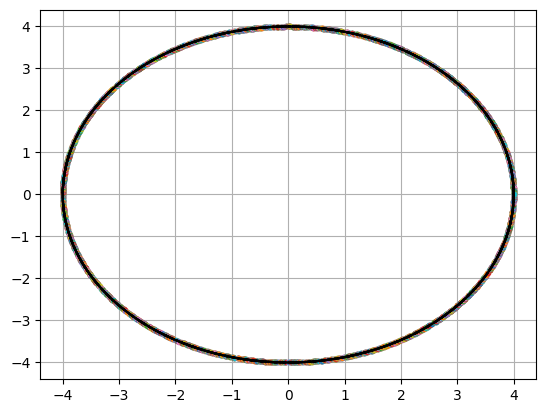

In [299]:
def affichage_chaine(Dataset):
    Dataset = sort(Dataset)
    chain_lower = sweeping_algorithm_lower(Dataset)
    chain_upper = sweeping_algorithm_upper(Dataset)

    #Plot des points
    for i in range(np.size(Dataset, axis=0)):
        plt.plot(Dataset[i][0], Dataset[i][1], marker=".")
    
    #Plot of seigment
    for i in range(len(chain_lower)-1):
        plt.plot([chain_lower[i][0],chain_lower[i+1][0]], [chain_lower[i][1],chain_lower[i+1][1]], 'k-')
    for i in range(len(chain_upper)-1):
        plt.plot([chain_upper[i][0],chain_upper[i+1][0]], [chain_upper[i][1],chain_upper[i+1][1]], 'k-')
    
    plt.grid()
    plt.show()
